# 1: Imports & Setup
Blaablabla


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file we saved in the previous step
# Make sure the path matches your folder structure
df = pd.read_csv('data/ttf_hourly.csv', index_col=0, parse_dates=True)

# Filter for just the last 3 months (approx 2000 hours) to make the charts readable
# If we plot all 2 years, it will look like a messy squiggle
df_recent = df.tail(2000)

print(f"Loaded TTF Gas Data. Showing from {df_recent.index[0]} to {df_recent.index[-1]}")

Loaded TTF Gas Data. Showing from 2025-01-22 10:00:00+00:00 to 2025-12-30 16:00:00+00:00


# Cell 2: The Data Fetcher (The Core Logic)
This is the most important part. We will fetch the 4 assets you trade.

EUA (Carbon): We use ECF=F (ICE EUA Futures). Note: If this fails (common with futures), we can swap to KEUA (EUA ETF).

TTF Gas: We use TTF=F (Dutch TTF Gas Futures).

Gold: We use GC=F (Gold Futures).

Bitcoin: We use BTC-USD.


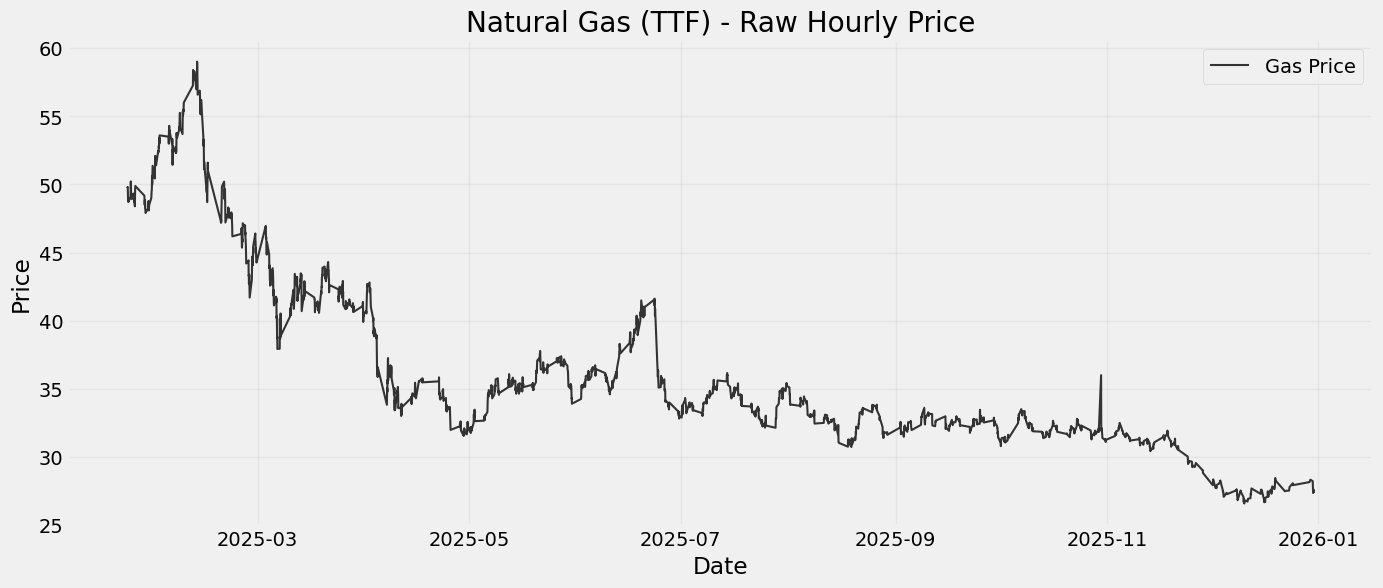

In [11]:
plt.figure(figsize=(15, 6))

# Plot Close Price
plt.plot(df_recent.index, df_recent['Close'], label='Gas Price', color='#333333', linewidth=1.5)

plt.title('Natural Gas (TTF) - Raw Hourly Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# ==========================================
# 2. FUNCTIONS
# ==========================================

def add_technical_indicators(df):
    """
    Adds SMA_50, SMA_200, Bollinger Bands, and RSI to the dataframe.
    """
    df = df.copy()
    
    # 1. Moving Averages (Hourly)
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    
    # 2. Bollinger Bands (20-hour, 2 std dev)
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (2 * rolling_std)
    df['BB_Lower'] = rolling_mean - (2 * rolling_std)
    
    # 3. RSI (14-hour)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop initial NaNs generated by rolling windows
    df.dropna(inplace=True)
    
    return df

def load_local_eua(file_path):
    """
    Loads local EUA daily data and upsamples it to hourly (forward fill).
    """
    print(f"📂 Loading local EUA file from: {file_path}...")
    try:
        # Check if file has extension, if not, try adding .csv or just read as is
        if not os.path.exists(file_path):
            # Try appending .csv just in case
            if os.path.exists(file_path + '.csv'):
                file_path += '.csv'
            else:
                print(f"❌ Error: File not found at {file_path}")
                return None

        # Read CSV (Handle '1,200.00' format)
        df = pd.read_csv(file_path, thousands=',')
        
        # Standardize columns
        df.rename(columns={'Price': 'Close', 'Vol.': 'Volume'}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        
        # Clean Volume (Convert '1.2K' to 1200)
        def clean_vol(x):
            if isinstance(x, str):
                x = x.replace('K', '000').replace('M', '000000').replace('.', '')
            return float(x) if x != '-' else 0
        
        if 'Volume' in df.columns:
            df['Volume'] = df['Volume'].apply(clean_vol)

        # Upsample to Hourly and Forward Fill
        df_hourly = df.resample('h').ffill()
        
        # Filter to match the date range of other assets
        mask = (df_hourly.index >= START_DATE) & (df_hourly.index <= END_DATE)
        df_hourly = df_hourly.loc[mask]
        
        print(f"✅ EUA Loaded: Converted daily rows to {len(df_hourly)} hourly rows.")
        return df_hourly
        
    except Exception as e:
        print(f"❌ Critical Error loading EUA: {e}")
        return None

print("done")

done


In [9]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

market_data = {}

# --- A. Download Yahoo Assets ---
print(f"⬇️ Downloading Hourly Data ({START_DATE.date()} to {END_DATE.date()})...")

for name, ticker in ASSETS.items():
    print(f"   Fetching {name} ({ticker})...")
    try:
        df = yf.download(ticker, start=START_DATE, end=END_DATE, interval='1h', auto_adjust=True, progress=False)
        
        # Flatten columns if MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
            
        df.dropna(how='all', inplace=True) # Drop empty rows
        market_data[name] = df
        print(f"   -> Success: {len(df)} rows.")
    except Exception as e:
        print(f"   -> Failed: {e}")

# --- B. Load Local EUA ---
eua_df = load_local_eua(EUA_FILE_PATH)
if eua_df is not None:
    market_data['EUA Carbon'] = eua_df

# --- C. Process & Save ---
print("\n⚙️ Calculating Indicators & Saving...")

for name, df in market_data.items():
    if df is None or df.empty:
        print(f"⚠️ Skipping {name} (No Data)")
        continue

    # 1. Apply Indicators
    analyzed_df = add_technical_indicators(df)
    
    # 2. Generate Filename (data/bitcoin_hourly.csv)
    safe_name = name.split(" ")[0].lower()
    filename = f"{DATA_FOLDER}/{safe_name}_hourly.csv"
    
    # 3. Save
    analyzed_df.to_csv(filename)
    
    # 4. Status Check
    last_price = analyzed_df['Close'].iloc[-1]
    last_rsi = analyzed_df['RSI'].iloc[-1]
    print(f"✅ {name}: Saved to {filename} | Price: {last_price:.2f} | RSI: {last_rsi:.2f}")

print("\n🚀 DONE! Your data is ready in the 'data/' folder.")

⬇️ Downloading Hourly Data (2024-01-01 to 2025-12-30)...
   Fetching TTF Gas (TTF=F)...
   -> Success: 4516 rows.
   Fetching Gold (GC=F)...
   -> Success: 11470 rows.
   Fetching Bitcoin (BTC-USD)...
   -> Success: 17340 rows.
📂 Loading local EUA file from: /home/ondrej-marvan/Documents/GitHub/OBS_DataScience/OBS_DataScience/Autumn 2025/2400-DS1SQL Python and SQL intro, SQL platforms/Project/data/European Union Allowance (EUA) Yearly Futures Historical Data...
✅ EUA Loaded: Converted daily rows to 8665 hourly rows.

⚙️ Calculating Indicators & Saving...
✅ TTF Gas: Saved to data/ttf_hourly.csv | Price: 27.36 | RSI: 46.97
✅ Gold: Saved to data/gold_hourly.csv | Price: 4390.30 | RSI: 56.09
✅ Bitcoin: Saved to data/bitcoin_hourly.csv | Price: 88534.91 | RSI: 73.62
✅ EUA Carbon: Saved to data/eua_hourly.csv | Price: 87.46 | RSI: 0.00

🚀 DONE! Your data is ready in the 'data/' folder.
